# Home Assignment No. 2: Practice

To solve this task efficiently, here are some practical suggestions:

* You are **HIGHLY RECOMMENDED** to read relevant documentation, e.g. for [python](https://docs.python.org/3/), [numpy](https://docs.scipy.org/doc/numpy/reference/), [matlpotlib](https://matplotlib.org/) and [sklearn](https://scikit-learn.org/stable/). Also remember to use tutorials, lecture slides, and other resources.


* Instead of rewriting existing code try to use **BUILT-IN METHODS** available in the libraries.


* To complete this part of the homework, you have to write some **CODE** directly inside the specified places in the notebook **CELLS**.


* In some problems you are asked to provide a short discussion of the results. In these cases you have to create a **MARKDOWN** cell with your comments right after the corresponding code cell.


* For every separate problem, you can get **INTERMEDIATE scores**.


* Your **SOLUTION** notebook **MUST BE REPRODUCIBLE**, i.e. if a reviewer executes your code, the output will be the same (with all the corresponding plots) as in your uploaded notebook. For this purpose, we suggest to fix random `seed` or (better) define `random_state=` inside every algorithm that uses some pseudorandomness.


* Your code must be readable. For this purpose, try to include **necessary** (and not more) comments inside the code. But remember: **GOOD CODE MUST BE SELF-EXPLANATORY**.


* Many `sklearn` algorithms support multithreading (Ensemble Methods, Cross-Validation, etc.). Check if the particular algorithm has `n_jobs` parameter and set it to `-1` to use all the cores.


* In the end you need to hand in a **single zip file** containing **two notebooks** (theory and practice) as well as the **html exported version** of this notebook (**4 files in total**).


To begin let's import the essential (for this assignment) libraries.

In [1]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import time

# Set default parameters for plots
plt.rcParams['figure.figsize'] = (12.0, 6.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

## Part 1: Linear SVM (face detection)

In this part you will need to implement a linear SVM classifier via the gradient descent algorithm.

First, let us have a look at the data we want to train our algorithm on.

In [2]:
# Load the faces data
data = loadmat('faces.mat')
labels = np.squeeze(data['Labels'])
data = data['Data']

Let us visualize some examples from the dataset. The dataset contains a set of $24 \times 24$ grayscale images labeled as face/non-face. Our goal is to train a classifier on this data. For calculations we will treat the samples as flattened vectors, the same way as they are stored. For visualization one needs to reshape the samples to $24 \times 24$ images.

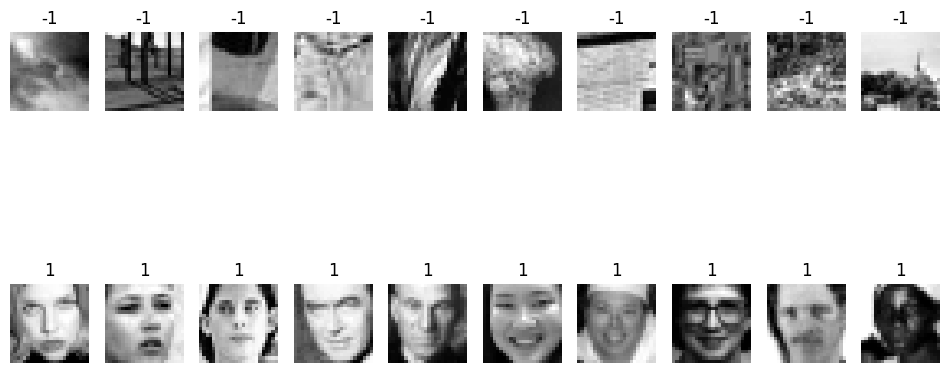

In [3]:
# Visualize some examples from the dataset.
samples_per_class = 10
classes = [-1, 1]
train_imgs = np.reshape(data, [-1, 24, 24], order='F')

for y, cls in enumerate(classes):
    idxs = np.flatnonzero(np.equal(labels, cls))
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = y * samples_per_class + i + 1
        plt.subplot(len(classes), samples_per_class, plt_idx)
        plt.imshow(train_imgs[idx])
        plt.axis('off')
        plt.title(cls)
plt.show()

## Task 1.1: SVM loss function [6 points]

In the lectures we have seen the SMO algorithm, which works in the dual domain. In this assignment we explore **Pegasos**, an optimization algorithm in the primal domain.

Recall the formulation of the SVM optimization problem as follows:

\begin{aligned}
& \min_{w, b}
& & \frac{1}{2}||w||^2 + C\sum_{i=1}^m \xi_i \\
& \ \text{ s.t.}
& & y^{(i)}(w^Tx^{(i)}+b) \geq 1-\xi_i, \; i = 1, \ldots, m \\
& & & \xi_i \geq 0, \; i = 1, \ldots, m \\
\end{aligned}

Let $f(x)=w^Tx+b$. The constraints can then be written as $y^{(i)}f(x^{(i)})\geq 1-\xi_i$. Together with the constraints $\xi_i \geq 0$ this leads to $\xi_i=\max(0, 1-y^{(i)}f(x^{(i)}))$. The above constraint optimization problem is therefore equivalent to the following **unconstrained** problem:

\begin{equation}
\min_{w, b} \frac{\lambda}{2}||w||^2 + \frac{1}{m}\sum_{i=1}^m \max(0, 1-y^{(i)}f(x^{(i)}))
\end{equation}

The first term in this objective is a regularization term (prevents overfitting) and the second term measures the classification loss. Here the parameter $\lambda=1/C$ is a **hyper-parameter** that controls the relative weight of  both losses.


**TODO**: Implement the **unconstrained** objective function for SVM in the following *svm_loss* function according to the specifications.

***HINT***: Write a small test for the provided values of w, b and C. Make sure your function passes the test.

In [4]:
def svm_loss(w, b, X, y, lambda_):
    """
    Computes the loss of a linear SVM w.r.t. the given data and parameters

    Args:
        w: Parameters of shape [num_features]
        b: Bias (a scalar)
        X: Data matrix of shape [num_data, num_features]
        y: Labels corresponding to X of size [num_data, 1]
        lambda_: Regularization hyper-parameter

    Returns:
        l: The value of the objective for a linear SVM

    """

    #######################################################################
    # TODO:                                                               #
    # Compute and return the value of the unconstrained SVM objective     #
    #                                                                     #
    #######################################################################
    f= X@w + b
    m = y.shape[0]
    l = lambda_ / 2.0 * np.linalg.norm(w)**2 + 1/m *np.sum(np.fmax(np.zeros(m), 1-y*f))


    #######################################################################
    #                         END OF YOUR CODE                            #
    #######################################################################
    return l


In [5]:
# Test your cost-function
w_0 = np.zeros(data.shape[1])
b_0 = 0.
l_0 = svm_loss(w_0, b_0, data, labels, 1.)

#######################################################################
# TODO:                                                               #
# What should be the expected output of svm_loss with the given params#
#                                                                     #
#######################################################################


expected_output = 1.0

#######################################################################
#                         END OF YOUR CODE                            #
#######################################################################

assert np.allclose(l_0, expected_output), "Something is wrong"
print("Well done!")

Well done!


## Task 1.2: SVM gradient [9 points]

**TODO**: Implement the gradient of the above unconstrained objective w.r.t. to the parameters $w$ and $b$. The gradient will be computed on a mini-batch (i.e., a random subset of the training set).

**Hint**: Don't worry about the fact that $\max(0, 1-y^{(i)}f(x^{(i)}))$ is not differentiable at $1-y^{(i)}f(x^{(i)})=0$. Just pick a one-sided gradient (this is called a subgradient for convex functions).

In [6]:
def svm_gradient(w, b, x, y, lambda_):
    """
    Compute gradient for SVM w.r.t. to the parameters w and b on a mini-batch (x, y)

    Args:
        w: Parameters of shape [num_features]
        b: Bias (a scalar)
        x: A mini-batch of training example [k, num_features]
        y: Labels corresponding to x of size [k]
        lambda_: Regularization hyper-parameter

    Returns:
        grad_w: The gradient of the SVM objective w.r.t. w of shape [num_features]
        grad_v: The gradient of the SVM objective w.r.t. b of shape [1]

    """
    #######################################################################
    # TODO:                                                               #
    # Compute the gradient for a particular choice of w and b.            #
    # Compute the partial derivatives and set grad_w and grad_b to the    #
    # partial derivatives of the cost w.r.t. both parameters in theta     #
    #                                                                     #
    #######################################################################
    #Initialize params
    
    grad_w = np.zeros(w.shape)
    grad_b = 0.0
    n_entries = y.shape[0]

    for idx in range(n_entries):
        if 1. - y[idx]*(np.dot(w.T, x[idx])+b) > 0:
            grad_w = grad_w - (y[idx]*x[idx])
            grad_b = grad_b - y[idx]

    #Compute final gradient parameters.
    grad_w = lambda_*w+grad_w/n_entries
    grad_b = grad_b/n_entries

    #######################################################################
    #                         END OF YOUR CODE                            #
    #######################################################################
    return grad_w, grad_b

In [7]:
# Test your implementation
x_ = np.ones([2, 10])
y_ = np.array([1, -1])
w_0 = np.zeros(10)
b_0 = 0.
grad_w, grad_b = svm_gradient(w_0, b_0, x_, y_, 1.)

#######################################################################
# TODO:                                                               #
# What should be the expected output of svm_gradient                  #
# with the given params                                               #
#                                                                     #
#######################################################################

expected_grad_w = 0
expected_grad_b = 0

#######################################################################
#                         END OF YOUR CODE                            #
#######################################################################

assert np.allclose(grad_w, expected_grad_w), "Something is wrong"
assert np.allclose(grad_b, expected_grad_b), "Something is wrong"
print("Well done!")

Well done!


## Task 1.3: SVM Solver [18 points]

You will implement the **Pegasos** algorithm - a variant of SGD - to solve for the parameters $w$ and $b$. 

The algorithm was introduced in the following [Paper](http://ttic.uchicago.edu/~nati/Publications/PegasosMPB.pdf) (see Figure 2). It is essentially Stochastic Gradient Descent on mini-batches + a specific choice for the learning rate giving convergence guarantees. The required steps are outlined in the following class implementation. For more details, please refer to the [Paper](http://ttic.uchicago.edu/~nati/Publications/PegasosMPB.pdf).

**TODO**: Implement the Pegasos algorithm according to specs. Tune the hyper-parameter **C** to get at least 90% accuracy on test.

In [8]:
class LinearSVM:
    def __init__(self, lambda_):
        self.lambda_ = lambda_
        self.w = None
        self.b = None
        
    def fit(self, X, y, num_iter=30000, num_per_batch=100, verbose=False):
        """
        Pegasos SVM solver.

        Args:
            X: Data matrix of shape [num_train, num_features]
            y: Labels corresponding to X of size [num_train]
            num_iter: Number of iterations
            num_per_batch: Number of samples per mini-batch

        Returns:
            theta: The value of the parameters after training

        """

        self.w = np.zeros(X.shape[1])
        self.b = 0.
        for t in range(num_iter):
            start = time.time()
            
            #######################################################################
            # TODO:                                                               #
            # Perform one step of stochastic gradient descent:                    #
            #   - Select a single training batch at random                        #
            #   - Update theta based on alpha and using gradient_function         #
            #                                                                     #
            #######################################################################
            
            # 1st Step: Sample a random mini-batch of size num_per_batch

            # 2nd Step: Compute the learning-rate n_t=1/(lambda*t)

            # 3rd Step: Compute the gradients and update the parameters as

            #1
            mini_batch = np.random.choice(X.shape[0], num_per_batch, replace=True)
            #2
            n_t=1/(self.lambda_*(t+1))
            #3
            grad_w, grad_b = svm_gradient(self.w, self.b, X[mini_batch], y[mini_batch], n_t)

            self.w = self.w - n_t*grad_w
            self.b = self.b - n_t*grad_b
            
            #######################################################################
            #                         END OF YOUR CODE                            #
            #######################################################################
            
            if verbose and t % 5000 == 0:
                exec_time = time.time() - start
                loss = svm_loss(self.w, self.b, X, y, self.lambda_)
                print(f'Iter {t}/{num_iter}: cost = {loss}  ({exec_time}s)')

    def predict_score(self, X):
        """
        Predicts a score for each sample (how confident the prediction is)
        
        Args:
            X: Data matrix of shape [num_train, num_features]
            
        Returns:
            Predictions of shape [num_train] - real numbers
        """
        #######################################################################
        # TODO:                                                               #
        # Write a function that predicts the "score" (condifence) for each    #
        # sample:                                                             #
        #                                                                     #
        ####################################################################### 
        preds = np.dot(X,self.w.T) + self.b

        #######################################################################
        #                         END OF YOUR CODE                            #
        #######################################################################

        return preds                
                
    def predict(self, X):
        """
        Predicts class labels on X.
        
        Args:
            X: Data matrix of shape [num_train, num_features]
            
        Returns:
            Predictions of shape [num_train]
        """
        #######################################################################
        # TODO:                                                               #
        # Write a function that predicts the class label {-1, 1} given the    #
        # data matrix X and trained params w and b. Use predict_score method  # 
        #                                                                     #
        #######################################################################

        preds = np.where(self.predict_score(X) > 0, 1, -1)

        #######################################################################
        #                         END OF YOUR CODE                            #
        #######################################################################

        return preds
    
    def score(self, X, y):
        """
        Calculates accuracy of the model on X.
        
        Args:
            X: Data matrix of shape [num_train, num_features]
            
        Returns:
            Model's accuracy score.
        """

        #######################################################################
        # TODO:                                                               #
        # Write a functions that calculates the performance of the model on X #
        # in terms of accuracy                                                #
        #                                                                     #
        #######################################################################)
        score = np.mean(self.predict(X) == y)

        #######################################################################
        #                         END OF YOUR CODE                            #
        #######################################################################
        
        return score

Now we are going to train the model. First let's split the data into train and test sets and normalize them.

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3)

In [10]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [11]:


# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (13882, 576)
Training labels shape:  (13882,)
Test data shape:  (5950, 576)
Test labels shape:  (5950,)


Now let us create a classifier instance and **fit** in on the training data.

In [12]:
# We will measure the execution time
start = time.time()

C = 0.1
lambda_ = 1/C
my_svm = LinearSVM(lambda_=lambda_)
my_svm.fit(X_train, y_train, num_iter=30000, num_per_batch=64, verbose=True)

exec_time = time.time()-start
print('Total exection time: {}s'.format(exec_time))

Iter 0/30000: cost = 1.3449599217275456  (0.0s)
Iter 5000/30000: cost = 1.5681873538652367  (0.0s)
Iter 10000/30000: cost = 1.6207322516309306  (0.0009770393371582031s)
Iter 15000/30000: cost = 1.6508476482862668  (0.0009770393371582031s)
Iter 20000/30000: cost = 1.672560260444077  (0.0s)
Iter 25000/30000: cost = 1.6893989024159575  (0.0s)
Total exection time: 8.044155597686768s


 We can have a look at what theta has learned to recognise as "face"

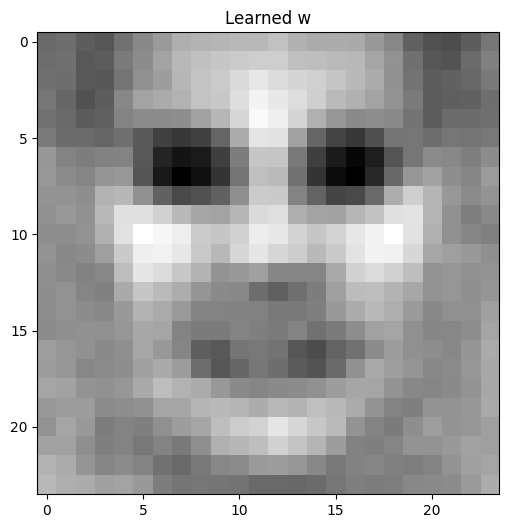

In [13]:
plt.imshow(np.reshape(my_svm.w, [24, 24], order='F'))
plt.title('Learned w')
plt.show()


Make the predictions, calculate the accuracy. Tune the hyperparameter C to get at least **90%** accuracy on the test!

In [14]:
print('Found C = {}, lambda = {}'.format(C, lambda_))
print('Accuracy train: {}'.format(my_svm.score(X_train, y_train)))
print('Accuracy test: {}'.format(my_svm.score(X_test, y_test)))

Found C = 0.1, lambda = 10.0
Accuracy train: 0.9103155164961821
Accuracy test: 0.906218487394958


## Part 2: Multiclass classification

## Task 2.1: ONE-VS-ALL SVM [12 points]

SVM is designed to solve a binary classification problem. What if we want to solve _multiclass classification_, meaning that we want to classify sample in 1 to K labels (with K>2)?

We can still use binary SVM to solve this problem in a _one-vs-all_ manner, meaning that we can train _K_ binary classifiers distinguishing class $k$ vs the rest of the classes.

You will implement multiclass classification using your LinearSVM implementation as follows:
1. Initialize MulticlassLinearSVM with _K_ LinearSVMs
2. For each _k=1..K_ labels:  
    a. Convert multiclass labels into binary labels: _y==1_ if _target==k_, _y==-1_ if _target!=k_  
    b. Train a binary classifier with this labels
3. To predict a label for an unknown sample:  
    a. Get a prediction score for each binary classifier  
    b. Return the label for which the score is the highest

**TODO**: Implement the multiclass SVM.

In [15]:
class MulticlassLinearSVM:
    def __init__(self, lambda_, K_classes):
        self.lambda_ = lambda_
        self.K_classes = K_classes
        #######################################################################
        # TODO:                                                               #
        # Initialize the class with K_classes instances of LinearSVM          #
        #######################################################################
        self.classifiers = [LinearSVM(lambda_) for _ in range(K_classes)]
        
        
    def fit(self, X, y, num_iter=30000, num_per_batch=100, verbose=False):
        """
        Fit K classifiers

        Args:
            X: Data matrix of shape [num_train, num_features]
            y: Labels corresponding to X of size [num_train]; values from 0..K_classes-1
            num_iter: Number of iterations
            num_per_batch: Number of samples per mini-batch


        """

        #######################################################################
        # TODO:                                                               #
        # Train K_classes binary classifiers                                  #
        #   - Convert integer labels 0..K-1 to binary labels 1 / -1 for a given #
        #     binary classifier                                               #
        #   - Train the current binary classifier                             #
        #                                                                     #
        #######################################################################
        
        for k in range(0, self.K_classes):
            start = time.time()
            
            current_classifier = self.classifiers[k]
            
            #######################################################################
            # TODO:                                                               #
            # Convert multiclass labels y to binary labels classifying            #
            # y_bin = 1  if y==k vs y!=k                                          #
            # y_bin = -1 if y!=k vs y!=k                                          #
            #######################################################################
            y_bin = np.where(y==k, 1 , -1)                              
            
            
            #######################################################################
            # TODO:                                                               #
            # Train the binary classifier with the converted labels               #
            # Don't forget to use this method's arguments                         #
            #######################################################################
            current_classifier.fit(X, y_bin, num_iter, num_per_batch, verbose)

            #######################################################################
            #                         END OF YOUR CODE                            #
            #######################################################################
            
            exec_time = time.time() - start
            print(f'Classifier {k+1}/{self.K_classes}: time ({exec_time}s)')
    
    def predict(self, X):
        """
        Predicts class labels on X.
        
        Args:
            X: Data matrix of shape [num_train, num_features]
            
        Returns:
            Predictions of shape [num_train] in {0..K_classes-1}
        """
        #######################################################################
        # TODO:                                                               #
        # Write a function that predicts the class label {0, .., K_classes-1} #
        # Predict the score for every binary classifier (use predict_score)   #
        # Return the label for which the classifier gives the greatest score  #
        #                                                                     #
        #######################################################################       
        num_samples = X.shape[0]
        pre = np.zeros((num_samples, self.K_classes))
        
        for k, current_classifier in enumerate(self.classifiers):
            pre[:, k] = current_classifier.predict_score(X).flatten()
        
        preds = np.argmax(pre, axis=1)

        
        
            

        #######################################################################
        #                         END OF YOUR CODE                            #
        #######################################################################

        return preds
    
    def score(self, X, y):
        """
        Calculates accuracy of the model on X.
        
        Args:
            X: Data matrix of shape [num_train, num_features]
            
        Returns:
            Model's accuracy score.
        """

        #######################################################################
        # TODO:                                                               #
        # Write a functions that calculates the performance of the model on X #
        # in terms of accuracy                                                #
        #                                                                     #
        #######################################################################
        
        score = np.mean(self.predict(X) == y)

        #######################################################################
        #                         END OF YOUR CODE                            #
        #######################################################################
        
        return score

### Simple (non-exhaustive) test
The code below should execute without errors and give ~25% accuracy

In [16]:
C = 10.0
lambda_ = 1/C

n_classes = 4
n_samples = 2000
data_random = np.random.randn(n_samples, 2)
np.random.seed(0)
labels_random = np.array([np.random.randint(n_classes) for i in range(n_samples)])

mc_svm = MulticlassLinearSVM(lambda_=lambda_, K_classes=n_classes)
mc_svm.fit(data_random, labels_random, num_iter=1000, num_per_batch=64, verbose=True)

pred = mc_svm.predict(data_random)
print('Accuracy: ', mc_svm.score(data_random, labels_random))

exec_time = time.time()-start
print('Total execution time: {}s'.format(exec_time))

Iter 0/1000: cost = 2.031652088345053  (0.0009777545928955078s)
Classifier 1/4: time (0.28028202056884766s)
Iter 0/1000: cost = 1.5626002072994971  (0.0s)
Classifier 2/4: time (0.24414706230163574s)
Iter 0/1000: cost = 1.8665973696540894  (0.0s)
Classifier 3/4: time (0.23242831230163574s)
Iter 0/1000: cost = 1.8734985371835633  (0.0009765625s)
Classifier 4/4: time (0.24610066413879395s)
Accuracy:  0.2565
Total execution time: 9.207553625106812s


## Classification on FashionMNIST dataset
We'll train a multiclass SVM on FashionMNIST dataset, containing $28\times28$ grayscale images of 10 categories of clothing.  
Let's load and visualize the dataset

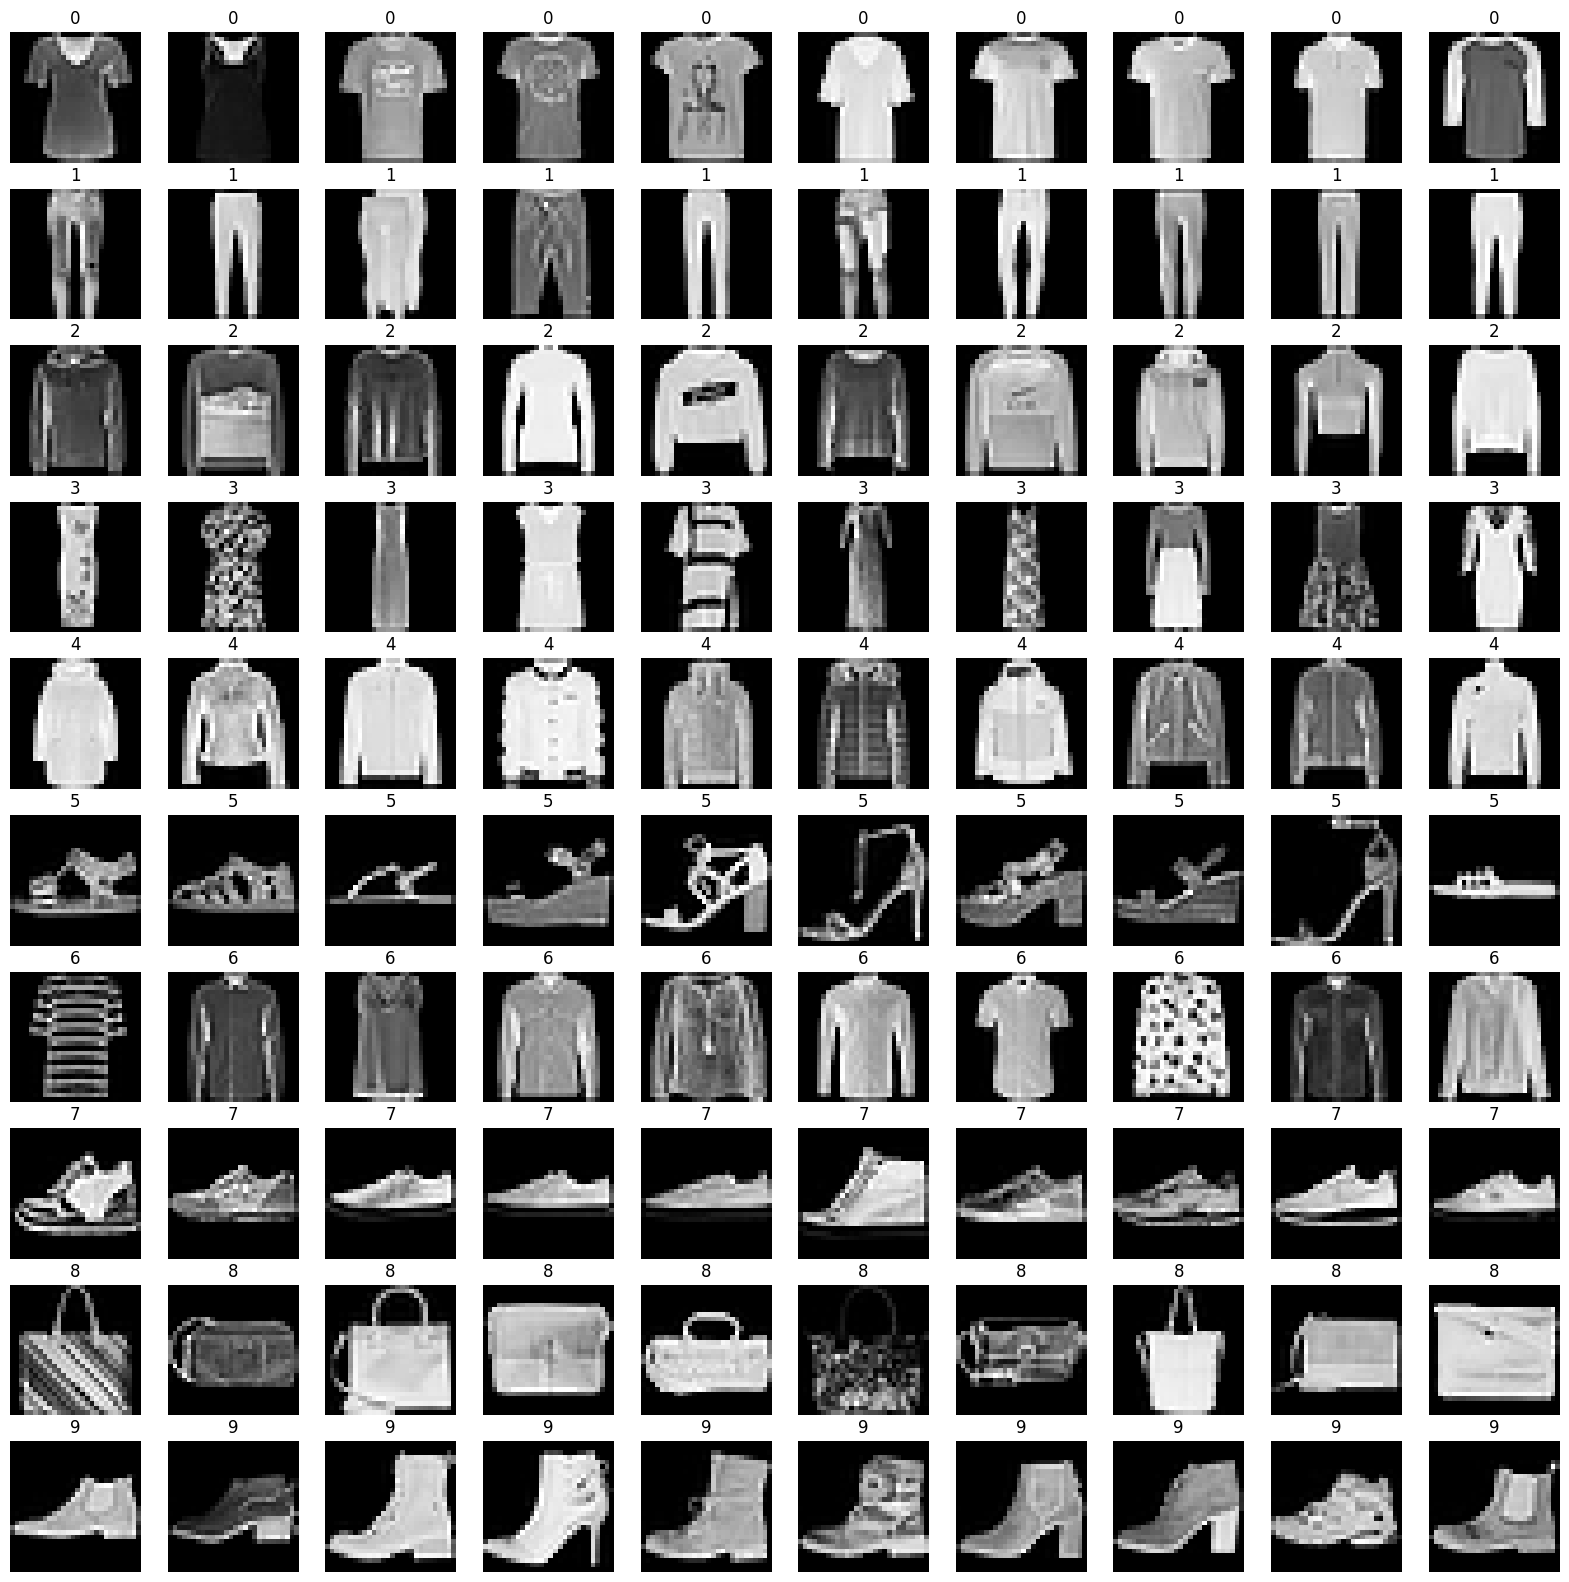

In [17]:
fmnist_data = np.load('fashion_mnist.npz')
X_train, X_test, y_train, y_test = fmnist_data['x_train'], fmnist_data['x_test'], fmnist_data['y_train'], fmnist_data['y_test']

# Visualize some examples from the dataset.
samples_per_class = 10
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
train_imgs = np.reshape(X_train, [-1, 28, 28], order='F')

plt.figure(figsize=(20,20))
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(np.equal(y_train, cls))
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = y * samples_per_class + i + 1
        plt.subplot(len(classes), samples_per_class, plt_idx)
        plt.imshow(train_imgs[idx])
        plt.axis('off')
        plt.title(cls)
plt.show()

Now let's normalize the data, train the model and visualize the weights for each classifier

In [18]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [19]:
C = 0.01
lambda_ = 1./C
my_svm = MulticlassLinearSVM(lambda_=lambda_, K_classes=10)

my_svm.fit(X_train_scaled, y_train, num_iter=10000, num_per_batch=64, verbose=True)

exec_time = time.time()-start
print('Total exection time: {}s'.format(exec_time))

Iter 0/10000: cost = 0.9910598727478299  (0.0009760856628417969s)
Iter 5000/10000: cost = 1.461026453702869  (0.0s)
Classifier 1/10: time (4.110583782196045s)
Iter 0/10000: cost = 0.9836584271767147  (0.0009770393371582031s)
Iter 5000/10000: cost = 1.6668263721426644  (0.0s)
Classifier 2/10: time (4.035969257354736s)
Iter 0/10000: cost = 1.0737059973013345  (0.0009772777557373047s)
Iter 5000/10000: cost = 1.5148500931483244  (0.0s)
Classifier 3/10: time (4.041555166244507s)
Iter 0/10000: cost = 1.0246668249032833  (0.0s)
Iter 5000/10000: cost = 1.4654831582945622  (0.0s)
Classifier 4/10: time (3.9056200981140137s)
Iter 0/10000: cost = 1.0115924617078156  (0.0s)
Iter 5000/10000: cost = 1.3761000333173916  (0.0s)
Classifier 5/10: time (3.9663474559783936s)
Iter 0/10000: cost = 0.9607049412123874  (0.0009772777557373047s)
Iter 5000/10000: cost = 1.0528012514546665  (0.0s)
Classifier 6/10: time (3.875312089920044s)
Iter 0/10000: cost = 1.021921349944578  (0.0009765625s)
Iter 5000/10000: co

In [20]:
print('C = {}, lambda = {}'.format(C, lambda_))
print('Accuracy train: {}'.format(my_svm.score(X_train_scaled, y_train)))
print('Accuracy test: {}'.format(my_svm.score(X_test_scaled, y_test)))

C = 0.01, lambda = 100.0
Accuracy train: 0.68175
Accuracy test: 0.6808333333333333


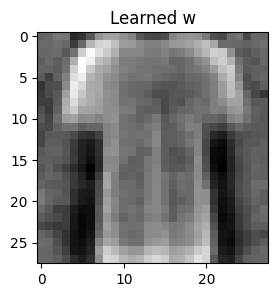

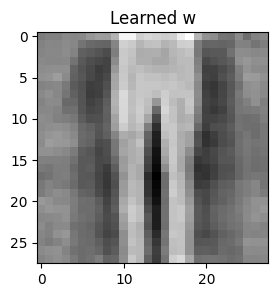

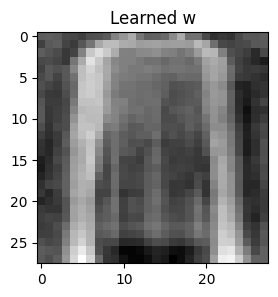

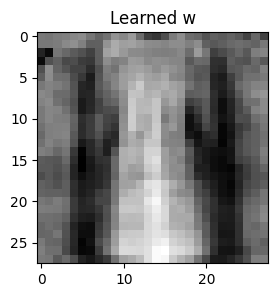

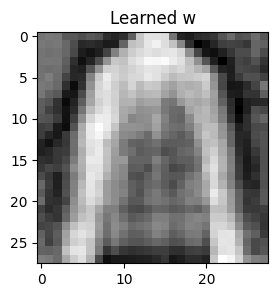

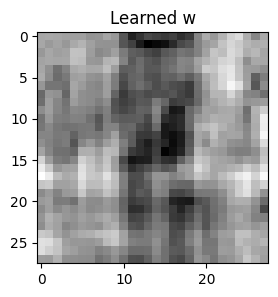

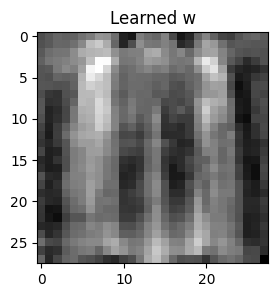

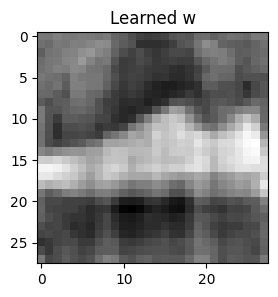

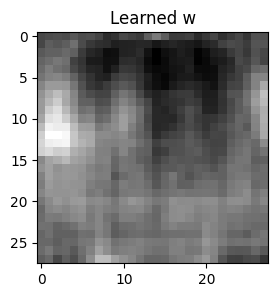

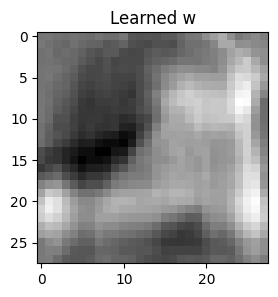

In [21]:
for classifier in my_svm.classifiers:
    plt.figure(figsize=(3,3))
    plt.imshow(np.reshape(classifier.w, [28, 28], order='F'))
    plt.title('Learned w')
    plt.show()

**TODO:** Tune the parameter **C** to get at least **80%** test accuracy

In [22]:
C = 3
lambda_ = 1./C
my_svm = MulticlassLinearSVM(lambda_=lambda_, K_classes=10)

my_svm.fit(X_train_scaled, y_train, num_iter=10000, num_per_batch=64, verbose=True)

exec_time = time.time()-start
print('Total exection time: {}s'.format(exec_time))

Iter 0/10000: cost = 50.46030214373138  (0.0s)
Iter 5000/10000: cost = 0.21756123518166692  (0.0009772777557373047s)
Classifier 1/10: time (2.2342638969421387s)
Iter 0/10000: cost = 102.57834168518627  (0.0009768009185791016s)
Iter 5000/10000: cost = 0.10505263676816959  (0.0s)
Classifier 2/10: time (2.0359208583831787s)
Iter 0/10000: cost = 44.220856075555275  (0.0009770393371582031s)
Iter 5000/10000: cost = 0.29631774983700193  (0.0s)
Classifier 3/10: time (2.3005897998809814s)
Iter 0/10000: cost = 89.28877926843323  (0.0s)
Iter 5000/10000: cost = 0.20906669997466906  (0.0s)
Classifier 4/10: time (2.2144691944122314s)
Iter 0/10000: cost = 58.93725288700642  (0.0009768009185791016s)
Iter 5000/10000: cost = 0.30148071096432316  (0.0s)
Classifier 5/10: time (2.297372817993164s)
Iter 0/10000: cost = 55.768449023188396  (0.0s)
Iter 5000/10000: cost = 0.19242364573981718  (0.0s)
Classifier 6/10: time (2.188969850540161s)
Iter 0/10000: cost = 41.402527219573216  (0.0009763240814208984s)
Ite

In [23]:
print('Found C = {}, lambda = {}'.format(C, lambda_))
print('Accuracy train: {}'.format(my_svm.score(X_train_scaled, y_train)))
print('Accuracy test: {}'.format(my_svm.score(X_test_scaled, y_test)))

Found C = 3, lambda = 0.3333333333333333
Accuracy train: 0.8595
Accuracy test: 0.8484722222222222


## Part 3: SVM with RBF kernel

## Task 3.1: Compare RBF and linear kernels [10 points]

**TODO:** Compare SVM with linear and RBF kernels on toy datasets. Implement *plot_classifiers_predictions* function. Make sure to plot the decision regions as in the previous assignment as well as the support vectors.

**HINT:** You may use ideas from this [webpage](https://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane.html#sphx-glr-auto-examples-svm-plot-separating-hyperplane-py).


In [24]:
from mlxtend.plotting import plot_decision_regions
from sklearn.datasets import make_moons, make_circles, make_blobs

In [25]:
def plot_classifiers_predictions(X, y, classifiers):
    """
    Plots the decision regions and support vectors of the classifiers
    fit on X and y.

    Args:
        X: Data matrix of shape [num_train, num_features]
        y: Labels of shape [num_train]
        classifiers: A list of classfifier objects

    """

    fig, axes = plt.subplots(ncols=len(classifiers), nrows=1, figsize=(16, 8))

    for classifier, axis in zip(classifiers, axes.flat):
        #######################################################################
        # TODO:                                                               #
        # Implement the plotting function                                     # 
        #                                                                     #
        #######################################################################

        # Fit the classifier to the data
        classifier.fit(X,y)
        # Plot the decision regions
        plot_decision_regions(X,y,clf=classifier, legend=2, ax=axis)
        # Plot the support vectors
        axis.scatter(
            classifier.support_vectors_[:, 0],
            classifier.support_vectors_[:, 1],
            s=100,
            linewidth=1,
            facecolors="none",
            edgecolors="k",
        )

    
        #######################################################################
        #                         END OF YOUR CODE                            #
        #######################################################################
        
        axis.set_title('{}, accuracy = {:.2f}'.format(
            classifier.__class__.__name__, classifier.score(X, y)))
    plt.show()
    

In [26]:
from sklearn.svm import SVC

linear_svc = SVC(kernel="linear")
rbf_svc = SVC(kernel="rbf")

classifiers = [linear_svc, rbf_svc]

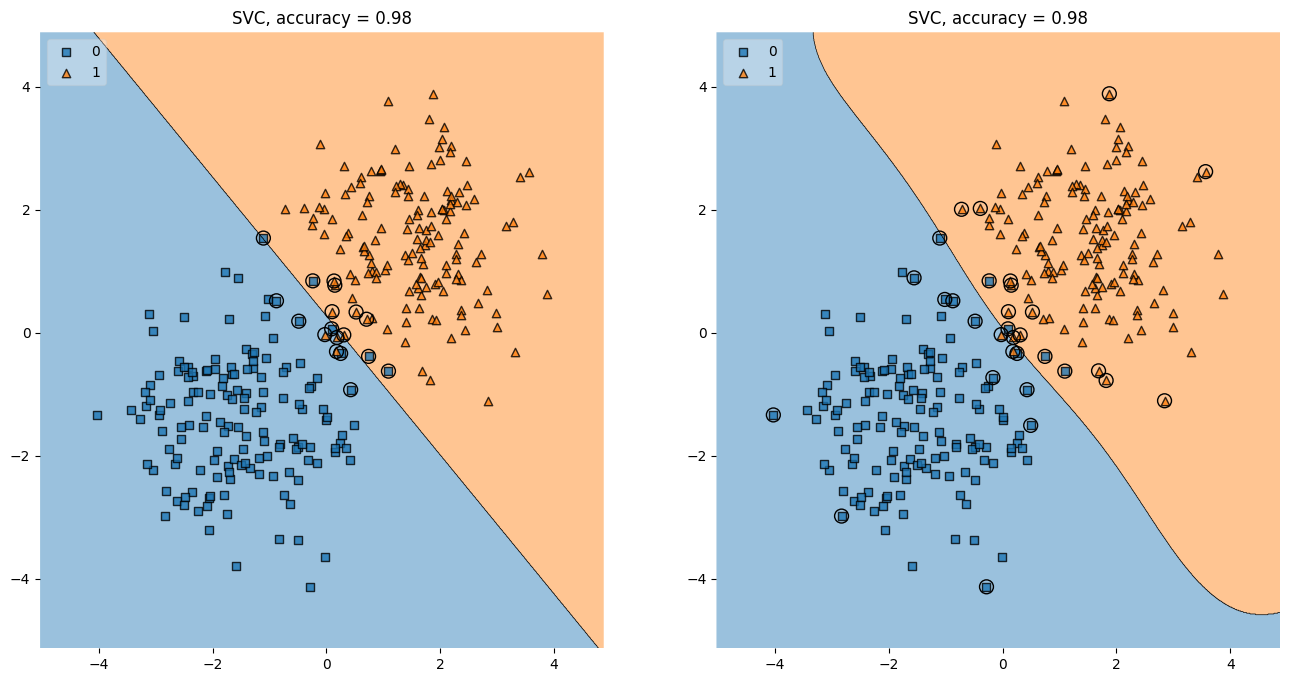

In [27]:
X_blobs, y_blobs = make_blobs(n_samples=300, centers=[[-1.5, -1.5], [1.5, 1.5]])
plot_classifiers_predictions(X_blobs, y_blobs, classifiers)

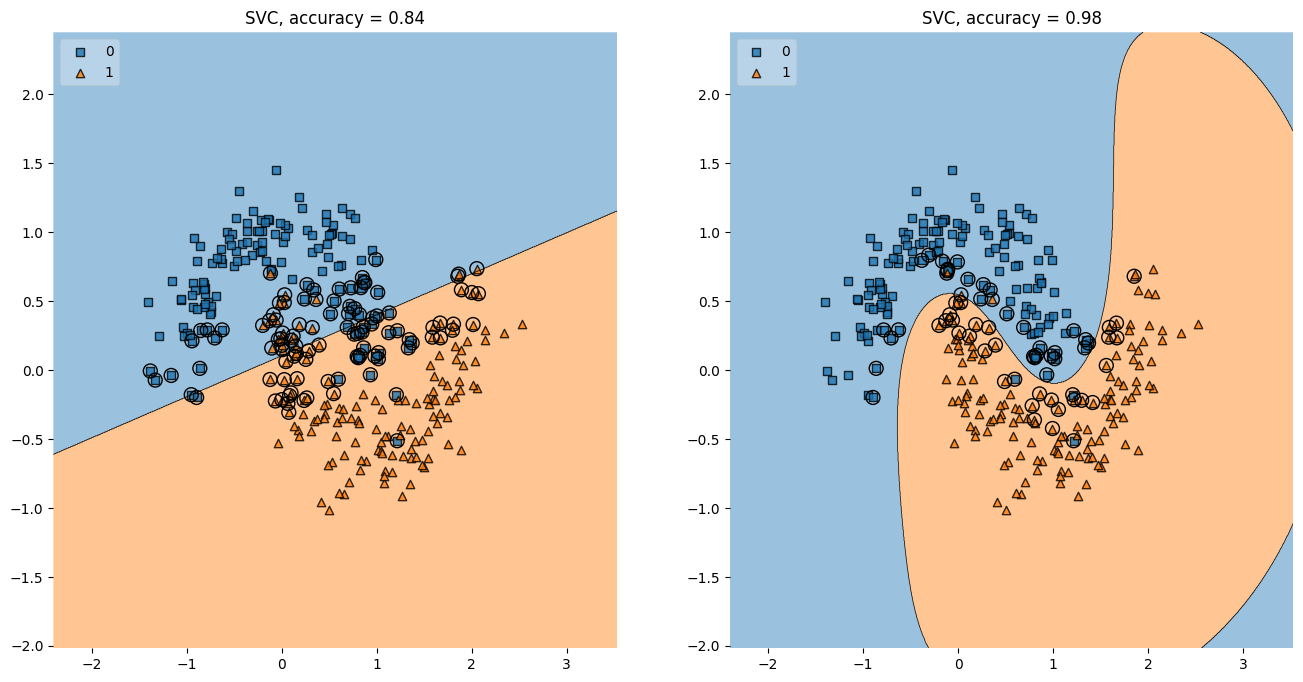

In [28]:
X_moons, y_moons = make_moons(n_samples=300, noise=0.2, random_state=0)
plot_classifiers_predictions(X_moons, y_moons, classifiers)

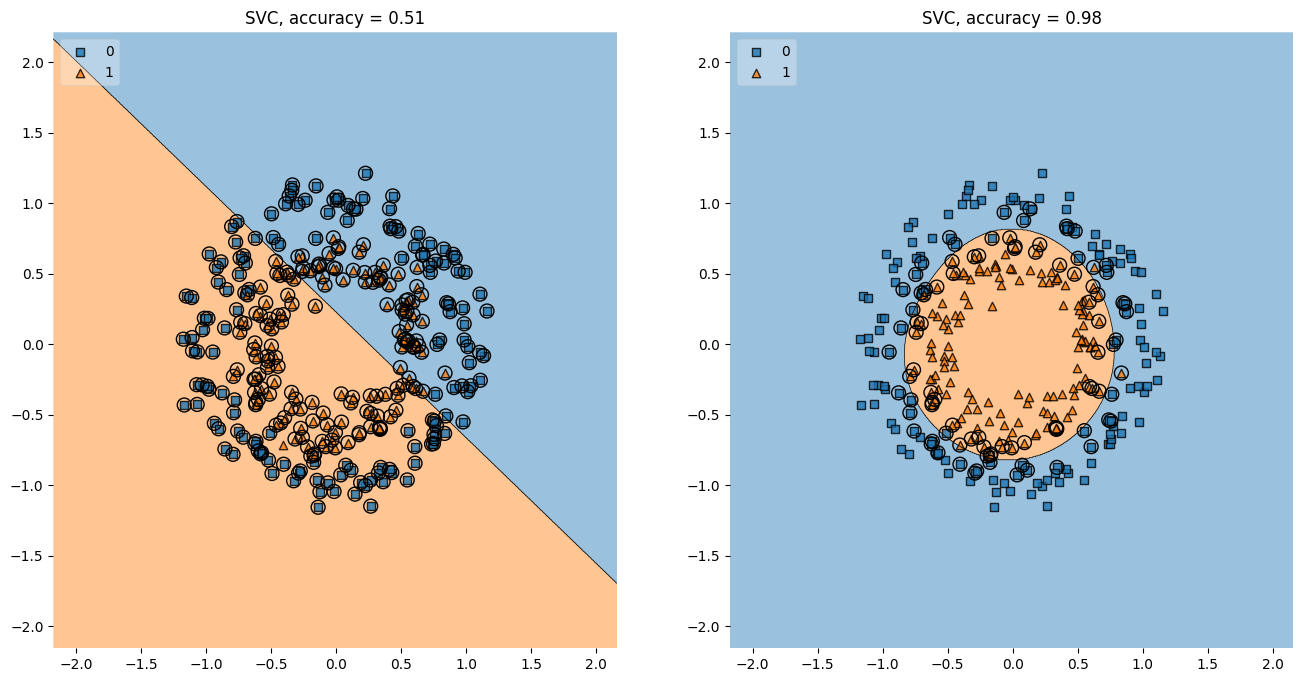

In [29]:
X_circles, y_circles = make_circles(n_samples=300, noise=0.1, random_state=0, factor=0.6)
plot_classifiers_predictions(X_circles, y_circles, classifiers)

In [30]:
svc_1 = SVC(kernel="rbf", C=0.001)
svc_2 = SVC(kernel="rbf", C=0.1)
svc_3 = SVC(kernel="rbf", C=1)
svc_4 = SVC(kernel="rbf", C=10)
svc_5 = SVC(kernel="rbf", C=100)
svc_6 = SVC(kernel="rbf", C=10000)

classifiers = [svc_1,svc_2,svc_3,svc_4,svc_5, svc_6]


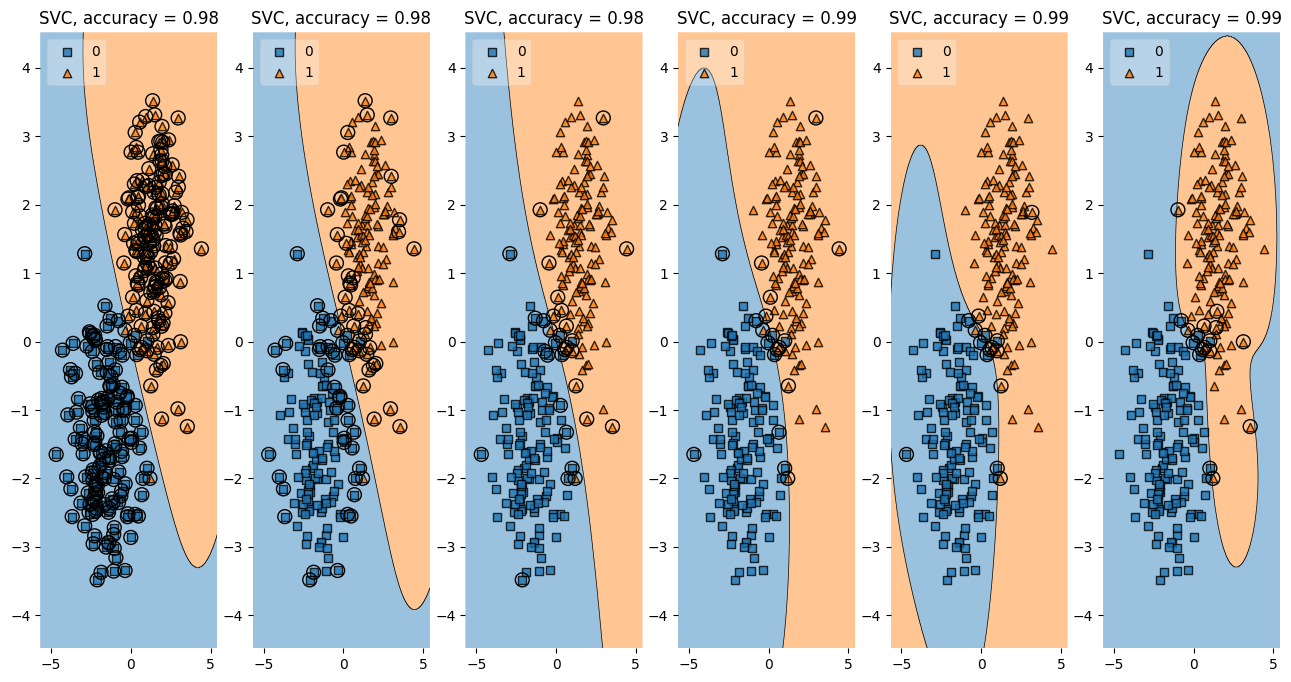

In [31]:
X_blobs, y_blobs = make_blobs(n_samples=300, centers=[[-1.5, -1.5], [1.5, 1.5]])
plot_classifiers_predictions(X_blobs, y_blobs, classifiers)

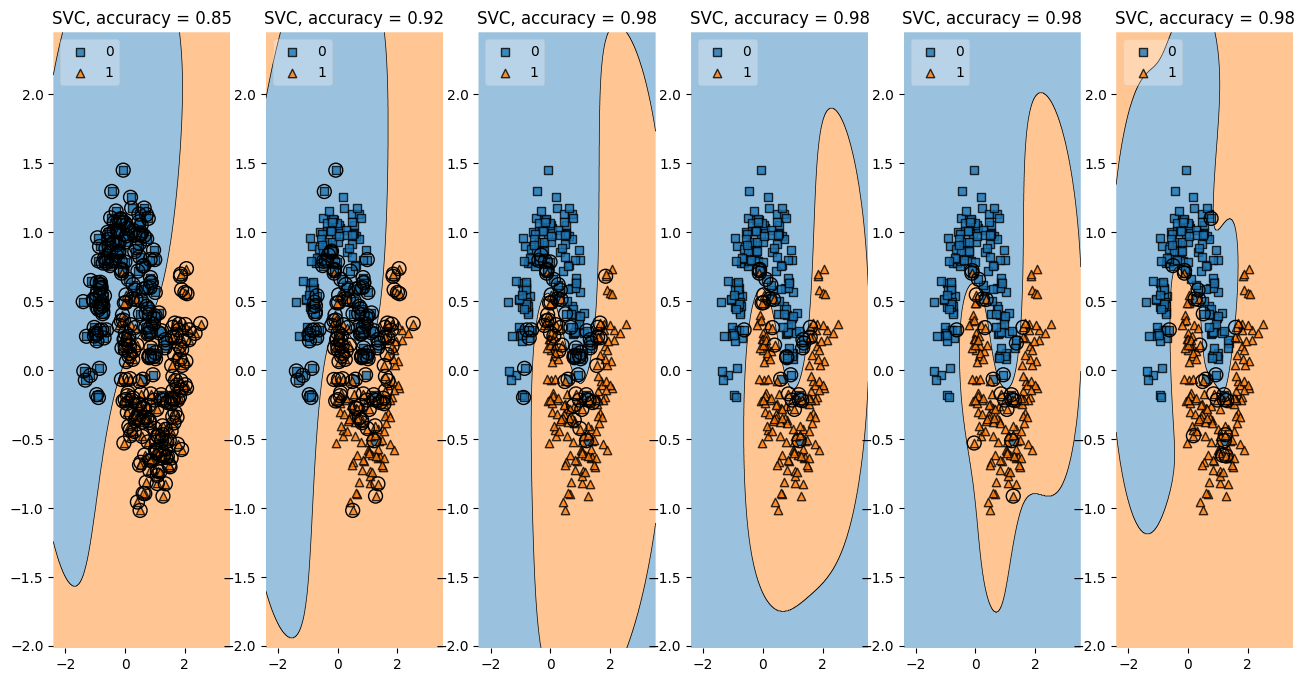

In [32]:
X_moons, y_moons = make_moons(n_samples=300, noise=0.2, random_state=0)
plot_classifiers_predictions(X_moons, y_moons, classifiers)

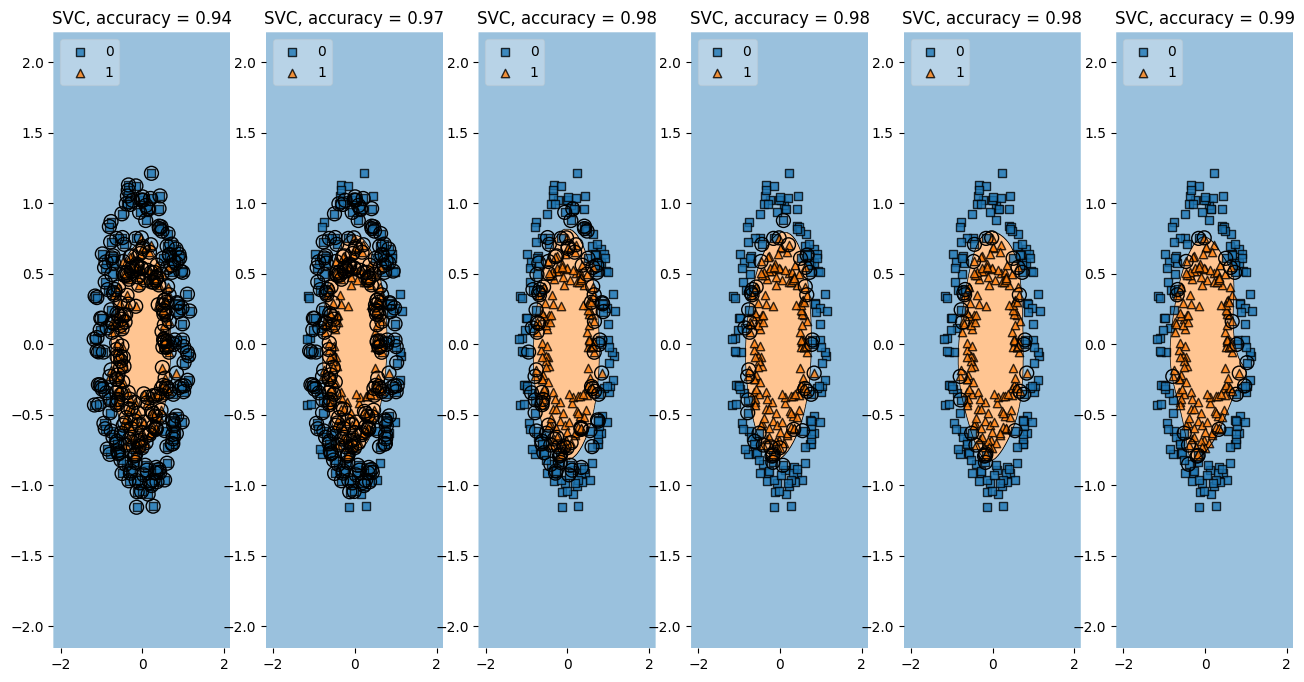

In [33]:
X_circles, y_circles = make_circles(n_samples=300, noise=0.1, random_state=0, factor=0.6)
plot_classifiers_predictions(X_circles, y_circles, classifiers)

## Task 3.2: Questions [6 points]

* Play with the hyperparameters. How do the hyper-parameters influence the classifier? What happens for extreme values of the hyper-parameters?

***Your Answer:***
For the linear kernel:  
Decreaseing the value of C increases the number of support vectors. This is because the margin is wider and more points are allowed to be inside the margin. Increasing the value of C decreases the number of support vectors. This is because the regularisation gets less weight. This leads to a smaller tolarance for outliers.

For the RBF kernel:  
With a low C value the regularisation gets more weight and the margin is wider. This leads to a less accurate model for the circle and moon data. This is because the model acceps more points inside the margin (wider margin). This leads to a less acurate approximation of the shape of the data (in this case). If the C is big it overfits to the data. If we look at the plot with the circles, we can see, that in the last plot (the one with the biggest C), the orange shape looks a bit misshaped. The intuitive best approximation, we get in the middle plots. This is because there, the regularization is balanced well. There are enough outlier accepted but not too many.




* Linear SVM vs. Gaussian Kernel SVM: Give advantages and disadvantages of both approaches. 

***Your Answer:***
Advantages of the linear SVM:
- The linear SVM is faster than the Gaussian Kernel SVM. 
- Works well if the data is linearly separable.

Disadvantages of the linear SVM:
- The linear SVM does not work well if the data is not linearly separable. This is because the linear SVM can only draw a straight line to separate the data. For data with a complex shape the rbf kernel is better.
- The gaussian kernel is more likely to overfit the training data.

* Linear SVM vs. Gaussian Kernel SVM: In what setting would you pick one method over the other? Answer in terms of number of training examples $m_{train}$ and feature dimension $d$

***Your Answer:***
If $m_{train}$ < $d$ then the linear SVM is better, because it is less likely to overfit the data. If $m_{train}$ > $d$ then I would in general pick the Gaussian Kernel, becaus it can better aproximate complex shapes (and higher dimensional data is more likely to have a complex shape). Because we have a lot of data the overfitting is less likely to happen.

## Part 4: Text classification

In this part you will be working on a text classification task. The IMDB dataset contains movie reviews labeled with positive/negative scores. Your goal here is to train a model to classify these texts.

Download the data from the [competition page](https://www.kaggle.com/t/a075874d324e402892eb5b4a31755fbb) and put it to your working directory.

We will use the *pandas* module to read, store and work with the data. The *pandas* module is a powerful library that provides us with a lot of useful functions and data structures that are designed to work with tabular data.

In [34]:
import pandas as pd
# Load the data
imdb_dataset_train = pd.read_csv("train_imdb_dataset.csv", index_col=0)
reviews_test = pd.read_csv("test_reviews.csv", index_col=0)

In *pandas* the main data structure is the *pd.DataFrame*. It represents the data in a form of a table. You can access the rows using the indices and the columns with the column names. 

In [35]:
imdb_dataset_train.head()

,review,sentiment
0,A wonderful little production. <br /><br />The...,positive
1,I thought this was a wonderful way to spend ti...,positive
2,Basically there's a family where a little boy ...,negative
3,"Petter Mattei's ""Love in the Time of Money"" is...",positive
4,I sure would like to see a resurrection of a u...,positive


In [36]:
reviews_test.head()

,review
0,"Val Kilmer... Love or loath him, sometimes he ..."
1,A spaceship in some unspecified future where h...
2,"I always loved this film. The music,story and ..."
3,"What a shocker. For starters, I couldn't stand..."
4,Dylan and Bobby are boyhood friends and they a...


Let us have a look at the first row of the training *DataFrame*.


In [37]:
i = 0
print("Sentiment:", imdb_dataset_train["sentiment"][i])
print("Review:", imdb_dataset_train["review"][i])

Sentiment: positive
Review: A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master's of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional 'dream' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell's murals decorating every surfac

## Task 4.1: Preprocessing [3 points]

One needs to transform the data to the format that can be used with the known classifiers. First, let us map sentiments to the categorical labels.

**TODO:** Transform the *sentiments* to *labels*, an array containing 0s and 1s. You can use *OrdinalEncoder* from *sklearn.preprocessing*.

In [38]:
from sklearn.preprocessing import OrdinalEncoder

#######################################################################
# TODO:                                                               #
# Transform sentiments to labels.                                     # 
#                                                                     #
#######################################################################
enc = OrdinalEncoder()
enc.fit(imdb_dataset_train[["sentiment"]])
y_train = enc.transform(imdb_dataset_train[["sentiment"]]).flatten()
#######################################################################
#                         END OF YOUR CODE                            #
#######################################################################

Then we need to represent each text as a bag of words.

Using *CountVectorizer* from *sklearn.feature_extraction.text* we can transform the *reviews* to a data matrix *X* of shape [num_reviews, vocabulary_size], where each row represents a single text and each column indicates the number of occurences of a specific word across the dataset.
Notice that the Vectorizer has a lot of useful arguments. These could potentially influence the performance of the models. Make sure to at least set *stop_words="english"*. This will make the Vectorizer ignore frequent words, that are useless for classification (e.g. articles, prepositions... ). Make sure you fit the Vectorizer to the union of the training and test reviews, otherwise you might miss some of the words.

In [39]:
from sklearn.feature_extraction.text import CountVectorizer

#######################################################################
# TODO:                                                               #
# Transform reviews to the words-frequency matrices                   #
# X_train and X_test                                                  #
#                                                                     #
#######################################################################
vectorizer = CountVectorizer()
vectorizer.fit_transform(pd.concat([imdb_dataset_train["review"], reviews_test["review"]]))
X_train = vectorizer.transform(imdb_dataset_train["review"])
X_test = vectorizer.transform(reviews_test["review"])

#######################################################################
#                         END OF YOUR CODE                            #
#######################################################################

In [40]:
# Let us check the shape of the data matrix
assert X_train.shape[1] == X_test.shape[1], "Train and test matrices should have the same number of tokens"
print("Number of tokens found:", X_train.shape[1])
print("Well done!")

Number of tokens found: 101895
Well done!


## Task 4.2: Multinomial Naive Bayes [3 points]

In this task you're asked to train a **Multinomial Naive Bayes** model on the reviews dataset. You're also asked to report the K-fold cross-validation. During the cross-validation the dataset gets split into K distinct subsets. At every iteration one of the subsets is removed from the training set, the model is trained on the rest and evaluated on the removed one. At the end the average of the K estimators is reported.

**TODO:** Train *MultinomialNB* model from *sklearn.naive_bayes*. Report the 5-fold cross-validation score.

In [41]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

#######################################################################
# TODO:                                                               #
# Transform reviews to the words-frequency matrix X.                  # 
#                                                                     #
#######################################################################
model = MultinomialNB()
cv_score = cross_val_score(model, X_train, y_train, cv=5).mean()


#######################################################################
#                         END OF YOUR CODE                            #
#######################################################################

In [42]:
print("Cross-validation accuracy score: {:.2f}".format(cv_score))

Cross-validation accuracy score: 0.85


Let us now train the model on the whole training dataset, make the predictions and save them to the submission file.

**TODO:** Train your model on the whole training set, make predictions and prepare a DataFrame for saving.

In [43]:
#######################################################################
# TODO:                                                               #
# Train the model on X_train, y_train and make predictions for X_test.#
#                                                                     #
#######################################################################

model = MultinomialNB()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

#######################################################################
#                         END OF YOUR CODE                            #
#######################################################################

In [44]:
#######################################################################
# TODO:                                                               #
# Create a submission DataFrame that has a single column "sentiment"  #
# With "positive"/"negative" values according to the predictions.     #
#                                                                     #
#######################################################################

submission = submission = pd.DataFrame({
    "sentiment": np.where(predictions == 1, "positive", "negative")
})

#######################################################################
#                         END OF YOUR CODE                            #
#######################################################################

submission["id"] = np.arange(submission.shape[0])
submission.to_csv("simple_baseline.csv", index=None)

In [45]:
submission.head()

,sentiment,id
0,positive,0
1,negative,1
2,positive,2
3,negative,3
4,positive,4


## Task 4.3: Time for the Competition! [10 points + 15 bonus]

In this task you need to improve the accuracy of the model as much as you can. Here are several techniques that you can use:

1) **Tune your hyper-parameters.** Try *GridSerachCV* function from *sklearn.model_selection* to find the best set of hyperparameters.

2) **Feature engineering.** Play with the representation of the textual data. We only tried one, but there are more (e.g. TF-IDF Vectorizer is another powerful method to transform text to a vector, taking into account the rareness of the words across the texts). Also do not hesitate to play with the arguments of the *Vectorizers*. 

3) **Change your model.** You are not restricted to train *Naive Bayes* only. You can use whatever algorithm you're already familiar with. Moreover, you can use the algorithms that you get to know during these 3 weeks of solving this assignment. E.g. give *RandomForests* a try!

When your model is trained, make the predictions for the test reviews and upload the file with those predictions to the [competition page](https://www.kaggle.com/t/a075874d324e402892eb5b4a31755fbb). You can find the formatting instructions to the submission file in the *Evaluation* section on the website.

After your submission is uploaded it will automatically get scored and will appear in the leaderboard. Before the deadline all the submissions are scored on 30% of the test set (*Public leaderboard*), after the deadline the submissions are rescored on the remaining part of the test set (*Private leaderboard*). The Private leaderboard may differ from the Public one. Notice, that the **final** order is accroding to the **Private leadearboard**. This is done to prevent you from overfitting to the Public leaderboard.

Notice that Kaggle limits you with **5** submissions per day, so make sure to test your model (e.g. with cross-validation) before you submit your predictions.

Make sure that the TAs can easily identify your submissions, i.e. don't use nicknames that cannot be linked to your name.

### Scoring rules
You get **3 points** if you beat the **simple baseline**, that is the classifier trained in task 4.2.

You get another **7 points** if you beat the **hard baseline**. This is the score of the hidden classifier that is trained by TAs, you don't have access to its code.

You get **5 bonus points** if you end up among **top-15** in the final leaderboard.

You get another **5 bonus points** if you end up in **top-10** in the final leaderboard.

And finally another **5 bonus points** will be given to those who end up in **top-5**.

In [46]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

imdb_dataset_train = pd.read_csv("train_imdb_dataset.csv", index_col=0)
reviews_test = pd.read_csv("test_reviews.csv", index_col=0)

enc = OrdinalEncoder()
enc.fit(imdb_dataset_train[["sentiment"]])
y_train_all = enc.transform(imdb_dataset_train[["sentiment"]]).flatten()

pattern = r'not\s+\w+'

# Apply the pattern to the DataFrame column
imdb_dataset_train['review'] = imdb_dataset_train['review'].str.replace(pattern, '', regex=True)
reviews_test['review'] = reviews_test['review'].str.replace(pattern, '', regex=True)

# Remove any extra spaces that may result from the replacement
imdb_dataset_train['review'] = imdb_dataset_train['review'].str.replace(r'\s+', ' ', regex=True).str.strip()
reviews_test['review'] = reviews_test['review'].str.replace(r'\s+', ' ', regex=True).str.strip()



#vectorizer = TfidfVectorizer(lowercase=False, stop_words=['film', 'to', 'br', 'english', 'definitly', 'and', 'the','of', 'is', 'in', 'it', 'The', 'this', 'that', 'for', 'but', 'with', 'was', 'as', 'not', 'on', 'was', 'as', 'on', 'movie', 'be', 'are', 'as', 'have', 'one', 'you', 'an', 'all','like', 'at', 'by', 'from', 'out', 'It', 'his', 'or', 'who', 'has', 'just', 'about', 'they', 'good', 'some', 'so', 'can', 'This', 'he', 'more', 'up', 'what','when', 'if', 'very', 'there', 'see', 'really', 'would', 'time', 'had', 'story', 'much', 'which', 'only', 'been', 'me', 'were', 'than', 'no', 'their', 'her', 'into', 'well', 'too', 'even', 'do', 'other', 'get', 'my', 'But', 'people', 'because', 'will', 'think', 'way', 'them', 'first', 'how', 'don'],token_pattern=r'(?u)\b\w+w*[a-zA-Z]\w*\b', norm='l2', smooth_idf=False, sublinear_tf=True, strip_accents='ascii')
#vectorizer = TfidfVectorizer(lowercase=False, stop_words=['film', 'to', 'br', 'english', 'definitly', 'and', 'it', 'the', 'bad', 'great', 'not', 'good', 'is', 'well', 'this', 'you', 'have', 'was', 'just', 'be', 'It', 'no', 'only', 'see', 'of', 'very', 'would', 'as', 'still', 'even', 'This', 'what', 'also', 'been', 'first', 'think', 'movie', 'bit', 'on', 'will', 'than'],token_pattern=r'(?u)\b\w+w*[a-zA-Z]\w*\b', norm='l2', smooth_idf=False, sublinear_tf=True, strip_accents='ascii')
vectorizer = TfidfVectorizer(lowercase=False, stop_words=['film', 'to', 'br', 'english', 'definitly', 'and', 'it', 'the'],token_pattern=r'(?u)\b\w+w*[a-zA-Z]\w*\b', norm='l2', smooth_idf=False, sublinear_tf=True, strip_accents='ascii')
XX=vectorizer.fit_transform(pd.concat([imdb_dataset_train["review"], reviews_test["review"]]))
X_train_all = vectorizer.transform(imdb_dataset_train["review"])

#train test split
X_train, X_val, y_train, y_val = train_test_split(X_train_all, y_train_all, test_size=0.2, random_state=42)


X_test = vectorizer.transform(reviews_test["review"])

## Multinomial Naive Bayes

In [47]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
model = MultinomialNB()
model.fit(X_train, y_train)
cv_score = cross_val_score(model, X_val, y_val, cv=5)
print("Cross-validation accuracy score: {:.2f}".format(cv_score.mean()))

Cross-validation accuracy score: 0.84


## Logistic Regression

In [48]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression
import numpy as np


clf1 = LogisticRegression(C=3.2,max_iter=1000, penalty = 'l2')
clf1.fit(X_train, y_train)
predictions = clf1.predict(X_val)
pred = clf1.predict(X_val)
cv_score = cross_val_score(clf1, X_val, y_val, cv=5)
print("Cross-validation accuracy score: {:.2f}".format(cv_score.mean()))



Cross-validation accuracy score: 0.88


In [49]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression
import numpy as np


clf = LogisticRegression(C=3.2,max_iter=1000, penalty = 'l2')
clf.fit(X_train_all, y_train_all)
predictions = clf.predict(X_val)
accuracy = np.mean(predictions == y_val)
print("Validation accuracy: {:.2f}".format(accuracy))

predictions = clf.predict(X_test)

submission = submission = pd.DataFrame({
    "sentiment": np.where(predictions == 1, "positive", "negative")
})

submission["id"] = np.arange(submission.shape[0])
submission.to_csv("logistic_regression.csv", index=None)

Validation accuracy: 0.97


## Support Vector Machine

In [50]:
from sklearn.svm import SVC

clf = SVC(C =5, gamma = 1, kernel ='rbf')
clf.fit(X_train, y_train)
predictions = clf.predict(X_val)
accuracy = np.mean(predictions == y_val)
print("Validation accuracy: {:.2f}".format(accuracy))


Validation accuracy: 0.90


In [51]:
from sklearn.svm import SVC
import numpy as np

clf = SVC(C =5, gamma = 1, kernel ='rbf')
clf.fit(X_train_all, y_train_all)
predictions = clf.predict(X_val)
accuracy = np.mean(predictions == y_val)
print("Validation accuracy: {:.2f}".format(accuracy))

predictions = clf.predict(X_test)

submission = submission = pd.DataFrame({
    "sentiment": np.where(predictions == 1, "positive", "negative")
})

submission["id"] = np.arange(submission.shape[0])
submission.to_csv("SVC.csv", index=None)

Validation accuracy: 1.00


## Data Analysis

In [52]:
from sklearn.linear_model import RidgeClassifier

clf = RidgeClassifier(tol=1e-2, solver="sparse_cg")
clf.fit(X_train, y_train)
pred = clf.predict(X_val)

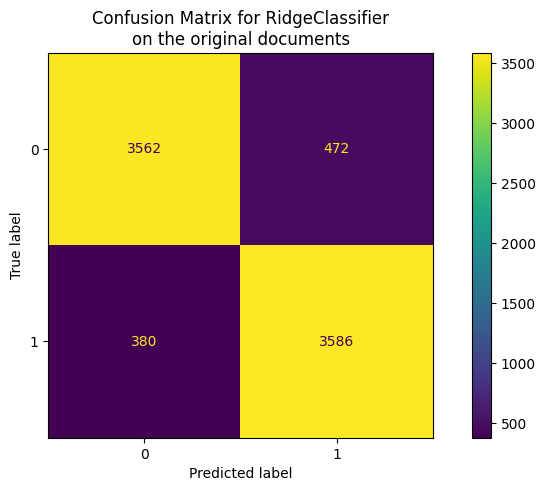

In [53]:
import matplotlib.pyplot as plt

from sklearn.metrics import ConfusionMatrixDisplay

feature_names = vectorizer.get_feature_names_out()
target_names = [0, 1]
fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(y_val, pred, ax=ax)
ax.xaxis.set_ticklabels(target_names)
ax.yaxis.set_ticklabels(target_names)
_ = ax.set_title(
    f"Confusion Matrix for {clf.__class__.__name__}\non the original documents"
)

Top 5 predictive keywords for class '1':
       1
0  great
1     is
2   well
3    you
4   good


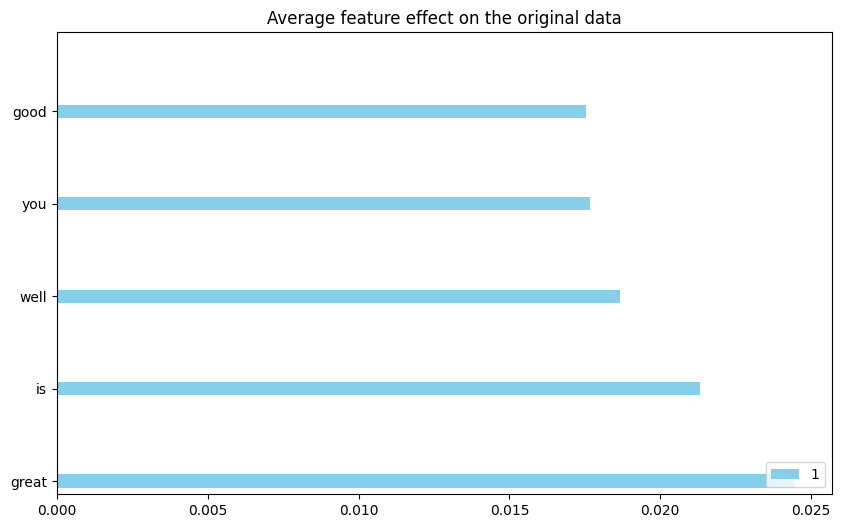

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_feature_effects():
    # Compute average feature effects for binary classification
    average_feature_effects = clf.coef_.flatten() * np.asarray(X_train.mean(axis=0)).ravel()

    # Extract top 5 predictive features (positive class)
    top5_indices = np.argsort(average_feature_effects)[-5:][::-1]
    top_features = feature_names[top5_indices]

    # Store the top 5 features in a DataFrame
    top = pd.DataFrame(top_features, columns=[target_names[1]])  # Label with the positive class name

    # Plotting setup
    bar_size = 0.25
    padding = 0.75
    y_locs = np.arange(len(top5_indices)) * (4 * bar_size + padding)

    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot positive class effects
    ax.barh(
        y_locs,
        average_feature_effects[top5_indices],
        height=bar_size,
        color='skyblue',
        label=target_names[1]
    )

    # Axis labels and formatting
    ax.set(
        yticks=y_locs,
        yticklabels=top_features,
        ylim=[-bar_size, len(top5_indices) * (4 * bar_size + padding) - bar_size],
    )
    ax.legend(loc="lower right")

    # Print and return the top features DataFrame
    print("Top 5 predictive keywords for class '{}':".format(target_names[1]))
    print(top)

    return ax

# Set the title after calling the function
_ = plot_feature_effects().set_title("Average feature effect on the original data")


Top 5 predictive keywords for class '0':
       0
0    bad
1   this
2  worst
3   have
4   only


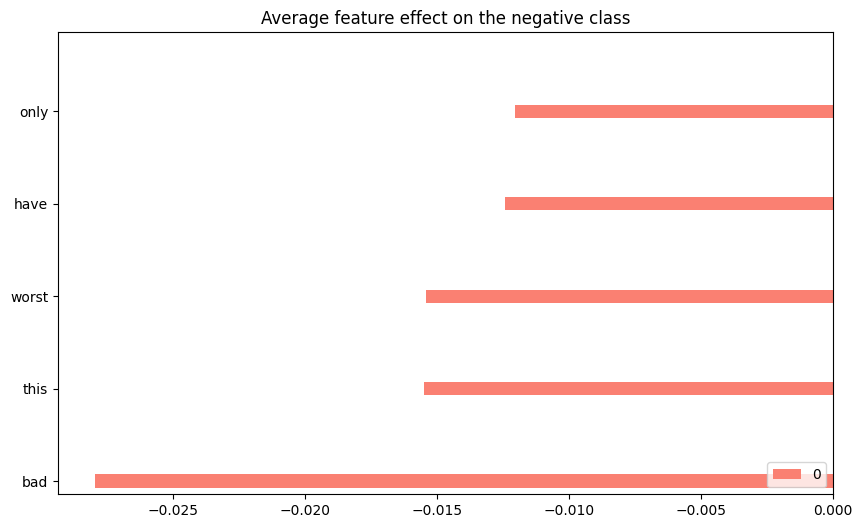

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_negative_feature_effects():
    # Compute average feature effects for binary classification
    average_feature_effects = clf.coef_.flatten() * np.asarray(X_train.mean(axis=0)).ravel()

    # Extract top 5 predictive features for the negative class (most negative coefficients)
    top5_indices = np.argsort(average_feature_effects)[:5]  # Selects smallest (most negative) coefficients
    top_features = feature_names[top5_indices]

    # Store the top 5 features in a DataFrame
    top = pd.DataFrame(top_features, columns=[target_names[0]])  # Label with the negative class name

    # Plotting setup
    bar_size = 0.25
    padding = 0.75
    y_locs = np.arange(len(top5_indices)) * (4 * bar_size + padding)

    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot negative class effects
    ax.barh(
        y_locs,
        average_feature_effects[top5_indices],
        height=bar_size,
        color='salmon',
        label=target_names[0]
    )

    # Axis labels and formatting
    ax.set(
        yticks=y_locs,
        yticklabels=top_features,
        ylim=[-bar_size, len(top5_indices) * (4 * bar_size + padding) - bar_size],
    )
    ax.legend(loc="lower right")

    # Print and return the top features DataFrame
    print("Top 5 predictive keywords for class '{}':".format(target_names[0]))
    print(top)

    return ax

# Set the title after calling the function
_ = plot_negative_feature_effects().set_title("Average feature effect on the negative class")


In [56]:
from sklearn import metrics
from sklearn.utils.extmath import density
from time import time

def benchmark(clf, custom_name=False):
    print("_" * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print(f"train time: {train_time:.3}s")

    t0 = time()
    pred = clf.predict(X_val)
    test_time = time() - t0
    print(f"test time:  {test_time:.3}s")

    score = metrics.accuracy_score(y_val, pred)
    print(f"accuracy:   {score:.3}")

    if hasattr(clf, "coef_"):
        print(f"dimensionality: {clf.coef_.shape[1]}")
        print(f"density: {density(clf.coef_)}")
        print()

    print()
    if custom_name:
        clf_descr = str(custom_name)
    else:
        clf_descr = clf.__class__.__name__
    return clf_descr, score, train_time, test_time

In [57]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.svm import LinearSVC

results = []
for clf, name in (
    (LogisticRegression(C=3.2, max_iter=1000), "Logistic Regression"),
    (RidgeClassifier(alpha=1.0, solver="sparse_cg"), "Ridge Classifier"),
    (KNeighborsClassifier(n_neighbors=100), "kNN"),
    (RandomForestClassifier(), "Random Forest"),
    # L2 penalty Linear SVC
    (LinearSVC(C=5, dual=False, max_iter=1000), "Linear SVC"),
    # L2 penalty Linear SGD
    (
        SGDClassifier(
            loss="log_loss", alpha=1e-4, n_iter_no_change=3, early_stopping=True
        ),
        "log-loss SGD",
    ),
    # NearestCentroid (aka Rocchio classifier)
    (NearestCentroid(), "NearestCentroid"),
    # Sparse naive Bayes classifier
    (ComplementNB(alpha=0.1), "Complement naive Bayes"),
):
    print("=" * 80)
    print(name)
    results.append(benchmark(clf, name))

Logistic Regression
________________________________________________________________________________
Training: 
LogisticRegression(C=3.2, max_iter=1000)
train time: 0.95s
test time:  0.00391s
accuracy:   0.895
dimensionality: 128887
density: 0.8260957272649685


Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(solver='sparse_cg')
train time: 0.576s
test time:  0.00391s
accuracy:   0.893
dimensionality: 128887
density: 0.8260957272649685


kNN
________________________________________________________________________________
Training: 
KNeighborsClassifier(n_neighbors=100)
train time: 0.0205s
test time:  17.1s
accuracy:   0.841

Random Forest
________________________________________________________________________________
Training: 
RandomForestClassifier()
train time: 1.53e+02s
test time:  0.489s
accuracy:   0.84

Linear SVC
________________________________________________________________________________
Training

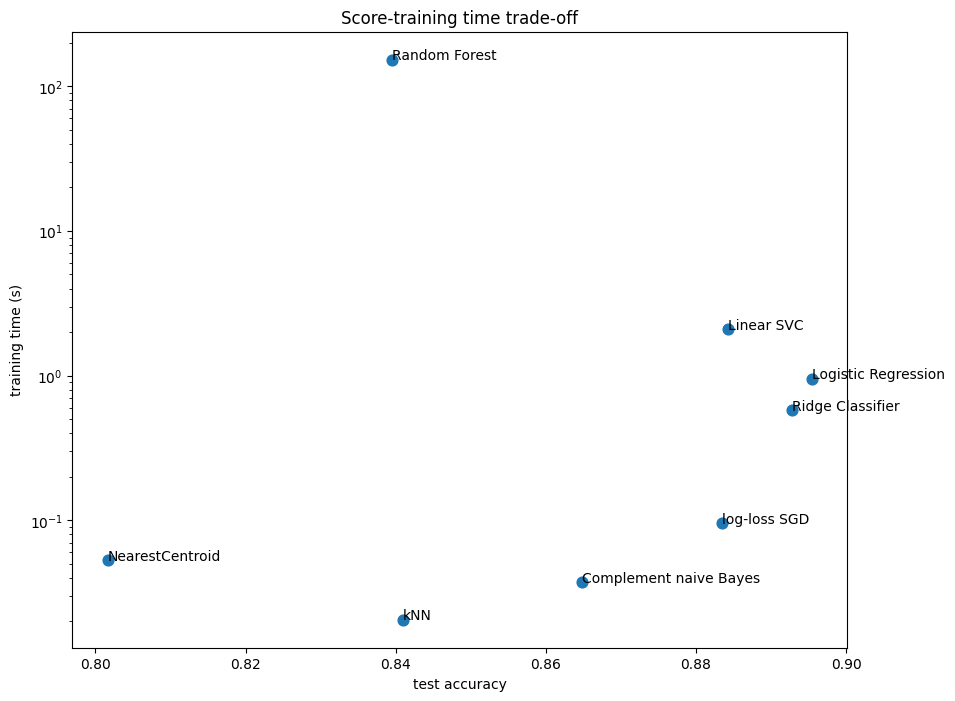

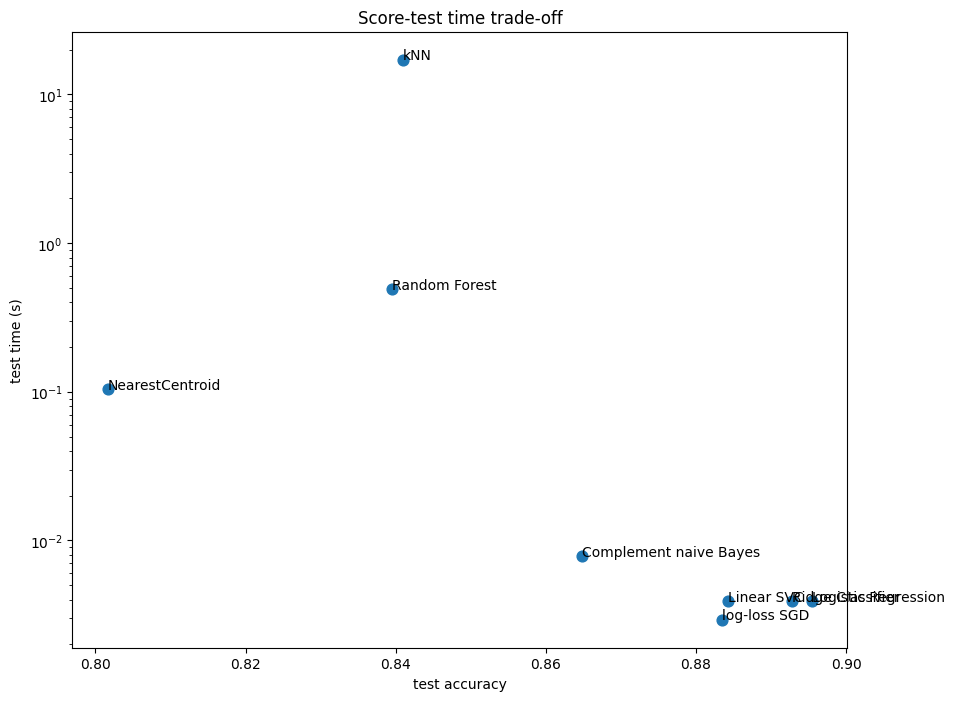

In [58]:
indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time)
test_time = np.array(test_time)

fig, ax1 = plt.subplots(figsize=(10, 8))
ax1.scatter(score, training_time, s=60)
ax1.set(
    title="Score-training time trade-off",
    yscale="log",
    xlabel="test accuracy",
    ylabel="training time (s)",
)
fig, ax2 = plt.subplots(figsize=(10, 8))
ax2.scatter(score, test_time, s=60)
ax2.set(
    title="Score-test time trade-off",
    yscale="log",
    xlabel="test accuracy",
    ylabel="test time (s)",
)

for i, txt in enumerate(clf_names):
    ax1.annotate(txt, (score[i], training_time[i]))
    ax2.annotate(txt, (score[i], test_time[i]))

In [59]:
import numpy as np
feature_names = vectorizer.get_feature_names_out()

# Count the non-zero entries in each column (feature) efficiently
# This counts how many documents each feature (word) appears in
feature_counts_train = np.diff(X_val[pred != y_val].tocsc().indptr)
feature_counts_test = np.diff(X_test.tocsc().indptr)
feature_counts = abs(feature_counts_train)

# Convert the result to a dictionary mapping feature names to counts
feature_count_dict = dict(zip(feature_names, feature_counts))

# (Optional) Sort by count if you want to see the most common features first
sorted_feature_counts = dict(sorted(feature_count_dict.items(), key=lambda item: item[1], reverse=True))
top_features = dict(sorted(feature_count_dict.items(), key=lambda item: item[1], reverse=True)[:20])
print(top_features.keys())

dict_keys(['of', 'is', 'in', 'this', 'that', 'for', 'but', 'with', 'The', 'was', 'on', 'as', 'movie', 'be', 'are', 'have', 'one', 'you', 'all', 'at'])


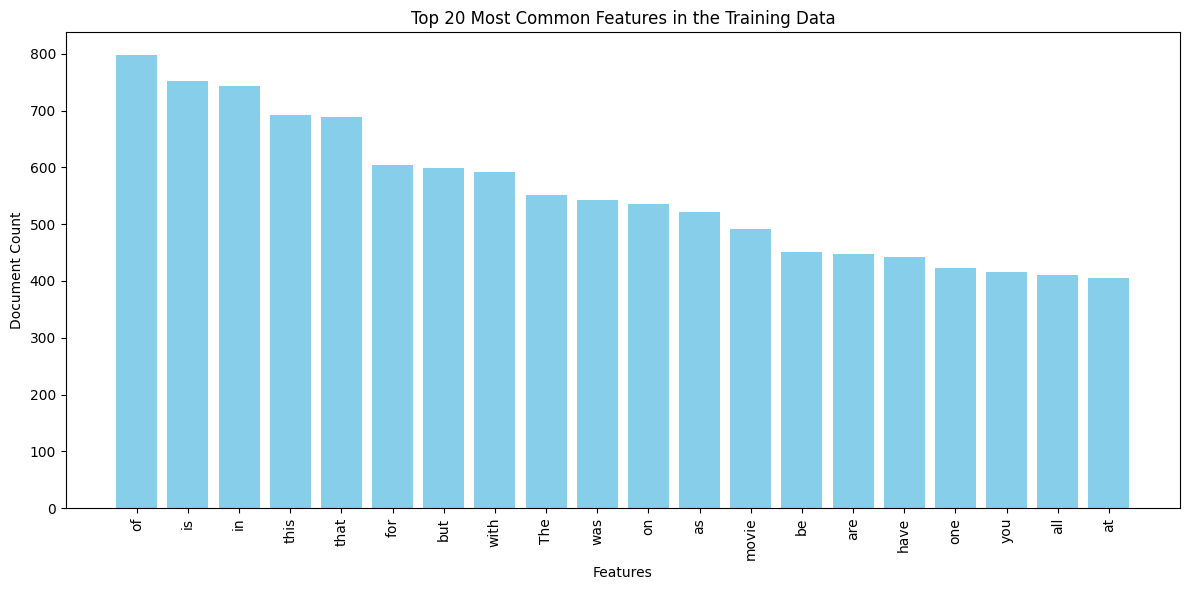

In [60]:
import matplotlib.pyplot as plt
# Plotting
plt.figure(figsize=(12, 6))
plt.bar(top_features.keys(), top_features.values(), color='skyblue')
plt.xlabel('Features')
plt.ylabel('Document Count')
plt.title('Top 20 Most Common Features in the Training Data')
plt.xticks(rotation=90)  # Rotate feature names for readability
plt.tight_layout()
plt.show()

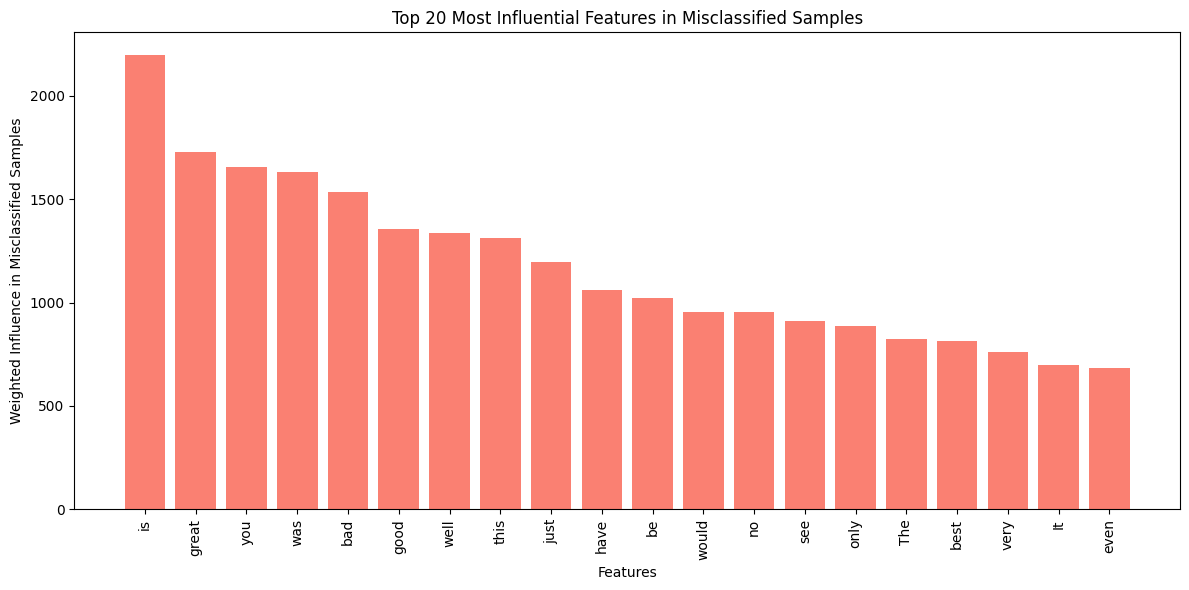

dict_keys(['is', 'great', 'you', 'was', 'bad', 'good', 'well', 'this', 'just', 'have', 'be', 'would', 'no', 'see', 'only', 'The', 'best', 'very', 'It', 'even'])


In [61]:
import numpy as np
import matplotlib.pyplot as plt

# Retrieve feature names from the vectorizer and coefficients from logistic regression model
feature_names = vectorizer.get_feature_names_out()
feature_importances = abs(clf1.coef_).flatten()

# Select misclassified samples
misclassified_samples = X_val[pred != y_val]

# Count the occurrences of each feature in the misclassified samples
feature_counts_misclassified = np.diff(misclassified_samples.tocsc().indptr)

# Map feature names to counts and multiply each count by its corresponding importance
feature_influence = {name: count * feature_importances[idx]
                     for idx, (name, count) in enumerate(zip(feature_names, feature_counts_misclassified))}

# Sort features by influence score (highest weight * count)
sorted_feature_influence = dict(sorted(feature_influence.items(), key=lambda item: item[1], reverse=True))

# Extract the top 20 most influential features
top_features = dict(list(sorted_feature_influence.items())[:20])

# Plotting the top features
plt.figure(figsize=(12, 6))
plt.bar(top_features.keys(), top_features.values(), color='salmon')
plt.xlabel('Features')
plt.ylabel('Weighted Influence in Misclassified Samples')
plt.title('Top 20 Most Influential Features in Misclassified Samples')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
print(top_features.keys())
